# Testing the Mutually Unbiased Basis methods for time independent Schrodinger equation

Using harmonic oscillator for testing

In [3]:
from numba import njit # compile python
import matplotlib.pyplot as plt # plotting facility
# import numpy as np

# from mub_qhamiltonian import MUBQHamiltonian # class for Mutually Unbiased Basis

In [4]:
import numpy as np
from scipy import fftpack # Tools for fourier transform
from scipy import linalg # Linear algebra for dense matrix


class MUBQHamiltonian(object):
    """
    Generate quantum Hamiltonian, H(x,p) = K(p) + V(x),
    for 1D system in the coordinate representation using mutually unbiased bases (MUB).
    """
    def __init__(self, *, x_grid_dim, x_amplitude, v, k, offset, **kwargs):
        """
         The following parameters must be specified
             x_grid_dim - the grid size
             x_amplitude - the maximum value of the coordinates
             v - the potential energy (as a function)
             k - the kinetic energy (as a function)
             kwargs is ignored
         """
        # saving the properties
        self.x_grid_dim = x_grid_dim
        self.x_amplitude = x_amplitude
        self.v = v
        self.k = k
        self.offset = offset

        # Check that all attributes were specified
        # make sure self.x_amplitude has a value of power of 2
        assert 2 ** int(np.log2(self.x_grid_dim)) == self.x_grid_dim, \
            "A value of the grid size (x_grid_dim) must be a power of 2"

        # get coordinate step size
        self.dx = 2. * self.x_amplitude / self.x_grid_dim

        # generate coordinate range
        k = np.arange(self.x_grid_dim)
        self.x = (k) * self.dx + self.offset
        # The same as
        # self.x = np.linspace(-self.x_amplitude, self.x_amplitude - self.dx , self.x_grid_dim)

        # generate momentum range as it corresponds to FFT frequencies
        self.p = (k - self.x_grid_dim / 2) * (np.pi / self.x_amplitude)

        # 2D array of alternating signs
        minus = (-1) ** (k[:, np.newaxis] + k[np.newaxis, :])
        # see http://docs.scipy.org/doc/numpy/reference/arrays.indexing.html
        # for explanation of np.newaxis and other array indexing operations
        # also https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html
        # for understanding the broadcasting in array operations    

        # Construct the momentum dependent part
        self.hamiltonian = np.diag(self.k(self.p))
        
        self.hamiltonian *= minus
        self.hamiltonian = fftpack.fft(self.hamiltonian, axis=1, overwrite_x=True)
        self.hamiltonian = fftpack.ifft(self.hamiltonian, axis=0, overwrite_x=True)
        self.hamiltonian *= minus

        # Add diagonal potential energy
        self.hamiltonian += np.diag(self.v(self.x))

    def get_eigenstate(self, n):
        """
        Return n-th eigenfunction
        :param n: order
        :return: a copy of numpy array containing eigenfunction
        """
        self.diagonalize()
        return self.eigenstates[n].copy()

    def get_energy(self, n):
        """
        Return the energy of the n-th eigenfunction
        :param n: order
        :return: real value
        """
        self.diagonalize()
        return self.energies[n]

    def diagonalize(self):
        """
        Diagonalize the Hamiltonian if necessary
        :return: self
        """
        # check whether the hamiltonian has been diagonalized
        try:
            self.eigenstates
            self.energies
        except AttributeError:
            # eigenstates have not been calculated so
            # get real sorted energies and underlying wavefunctions
            # using specialized function for Hermitian matrices
            self.energies, self.eigenstates = linalg.eigh(self.hamiltonian)

            # extract real part of the energies
            self.energies = np.real(self.energies)

            # covert to the formal convenient for storage
            self.eigenstates = self.eigenstates.T

            # normalize each eigenvector
            for psi in self.eigenstates:
                psi /= linalg.norm(psi) * np.sqrt(self.dx)

            # Make sure that the ground state is non negative
            np.abs(self.eigenstates[0], out=self.eigenstates[0])

        return self



First energies for harmonic oscillator with omega = 8.0
[  7.46121116  15.45868456  23.45630628  31.45401444  39.45178031
  47.44958746  55.4474253   63.44528648  71.44316558  79.44105844
  87.43896177  95.43687289 103.43478956 111.43270989 119.43063225
 127.4285552  135.42647747 143.42439792 151.42231552 159.42022932]


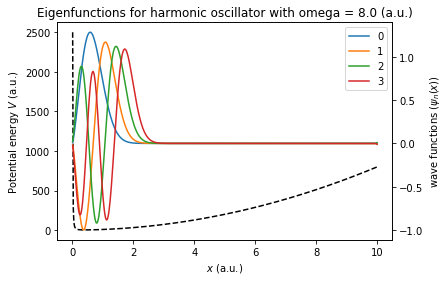

In [7]:

# Find energies of a harmonic oscillator V = 0.5*(omega*x)**2

@njit
def v(x):
    """
    Potential energy
    """
    return 8. * (x ** 2) + (1. / (4. * x**2))

@njit
def k(p):
    """
    Non-relativistic kinetic energy
    """
    return 0.5 * p ** 2

harmonic_osc = MUBQHamiltonian(
                    x_grid_dim=512,
                    x_amplitude=5.,
                    v=v,
                    k=k,
                    offset = 0.01
                )

# We will use the double axes plot to simultaneously the potential energy and wave functions.
# See the tutorial  https://matplotlib.org/examples/api/two_scales.html

fig, ax1 = plt.subplots()
ax1.plot(
    harmonic_osc.x,
    harmonic_osc.v(harmonic_osc.x),
    '--k',
)
ax1.set_ylabel('Potential energy $V$ (a.u.)')
ax1.set_xlabel('$x$ (a.u.)')

ax2 = ax1.twinx()

# plot eigenfunctions
for n in range(4):
    ax2.plot(harmonic_osc.x, harmonic_osc.get_eigenstate(n).real, label=str(n))

print("\n\nFirst energies for harmonic oscillator with omega = {}".format(omega))
print(harmonic_osc.energies[:20])

plt.title("Eigenfunctions for harmonic oscillator with omega = {} (a.u.)".format(omega))
#plt.xlabel('$x$ (a.u.)')
ax2.set_ylabel('wave functions ($\\psi_n(x)$)')
plt.legend()
plt.show()

In [6]:
# # Find energies of a harmonic oscillator V = 0.5*(omega*x)**2

# @njit
# def v(x):
#     """
#     Potential energy
#     """
#     return 8. * (x ** 2) + (1. / (4. * x**2))

# @njit
# def k(p):
#     """
#     Non-relativistic kinetic energy
#     """
#     return 0.5 * p ** 2

# harmonic_osc = MUBQHamiltonian(x_grid_dim=512, x_amplitude=3., v=v, k=k, offset=0.0001)

# # We will use the double axes plot to simultaneously the potential energy and wave functions.
# # See the tutorial  https://matplotlib.org/examples/api/two_scales.html

# fig, ax1 = plt.subplots()
# ax1.plot(
#     harmonic_osc.x,
#     harmonic_osc.v(harmonic_osc.x),
#     '--k',
# )
# ax1.set_ylabel('Potential energy $V$ (a.u.)')
# ax1.set_xlabel('$x$ (a.u.)')

# ax2 = ax1.twinx()

# # plot eigenfunctions
# for n in range(4):
#     ax2.plot(harmonic_osc.x , harmonic_osc.get_eigenstate(n).real, label=str(n))

# print("\n\nFirst energies for harmonic oscillator with omega = ")
# print(harmonic_osc.energies[:20])

# plt.title("Eigenfunctions for harmonic oscillator with omega = (a.u.)")
# #plt.xlabel('$x$ (a.u.)')
# ax2.set_ylabel('wave functions ($\\psi_n(x)$)')
# plt.legend()
# plt.show()